# Plot sea ice, wind stress, and Ekman pumping in Melville Bay
## Supplemental figures

This notebook accounts for the presence/absence of sea ice while calculating wind stress curl and $w_{ek}$

When sea ice is present, wind stress is zero (e.g., fast ice along Melville Bay coastline buffers ocean from wind forcing). <br>
When there is open water (sea ice conc < 50%) wind causes a drag force on ocean surface.

In [16]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import math
import calendar
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# import daily averaged sea ice data (flagged data already masked)
input_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/era5/sea_ice/daily')
seaice_1d_2018to2020 = xr.open_dataset(input_dir / "seaice_2018to2020_1d.nc")

In [3]:
# import daily averaged wind stress data
input_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/era5/wind/daily')
tau_1d_2018to2020 = xr.open_dataset(input_dir / "tau_1d_2018to2020.nc")

In [4]:
# mask grid cells with > 20% land cover
tau_1d_2018to2020_masked = tau_1d_2018to2020.where(tau_1d_2018to2020.lsm < 0.2, 0)

In [5]:
tau_1d_2018to2020_masked

<xarray.Dataset>
Dimensions:    (time: 1096, latitude: 81, longitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
    number     int32 0
    step       timedelta64[ns] 00:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 80.0 79.75 79.5 79.25 ... 60.5 60.25 60.0
  * longitude  (longitude) float64 -90.0 -89.75 -89.5 ... -40.5 -40.25 -40.0
Data variables:
    iews       (time, latitude, longitude) float32 0.0 0.0 ... -0.05606 -0.0614
    inss       (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.2359 0.2396
    lsm        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

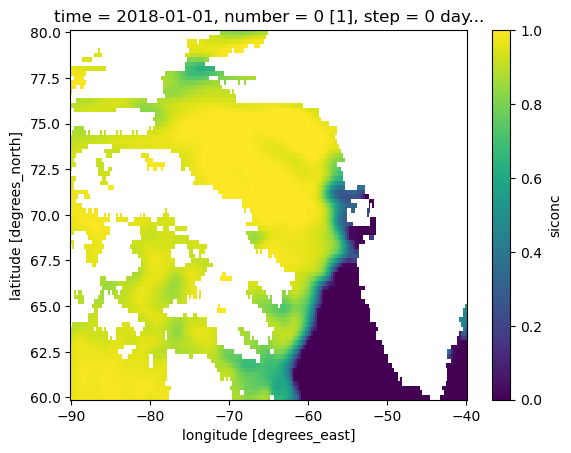

In [6]:
# just take a look at example sea ice data
seaice_1d_2018to2020.siconc.isel(time=0).plot()

## Overlay sea ice concentration and wind stress data on the same plot

In [7]:
# first take monthly average for each variable
seaice_month_2018to2020 = seaice_1d_2018to2020.groupby("time.month").mean(dim='time')
tau_month_2018to2020 = tau_1d_2018to2020_masked.groupby("time.month").mean(dim='time')

First, look at all of Baffin Bay

C:\Users\marie\anaconda3\envs\phd_omg-narwhals\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


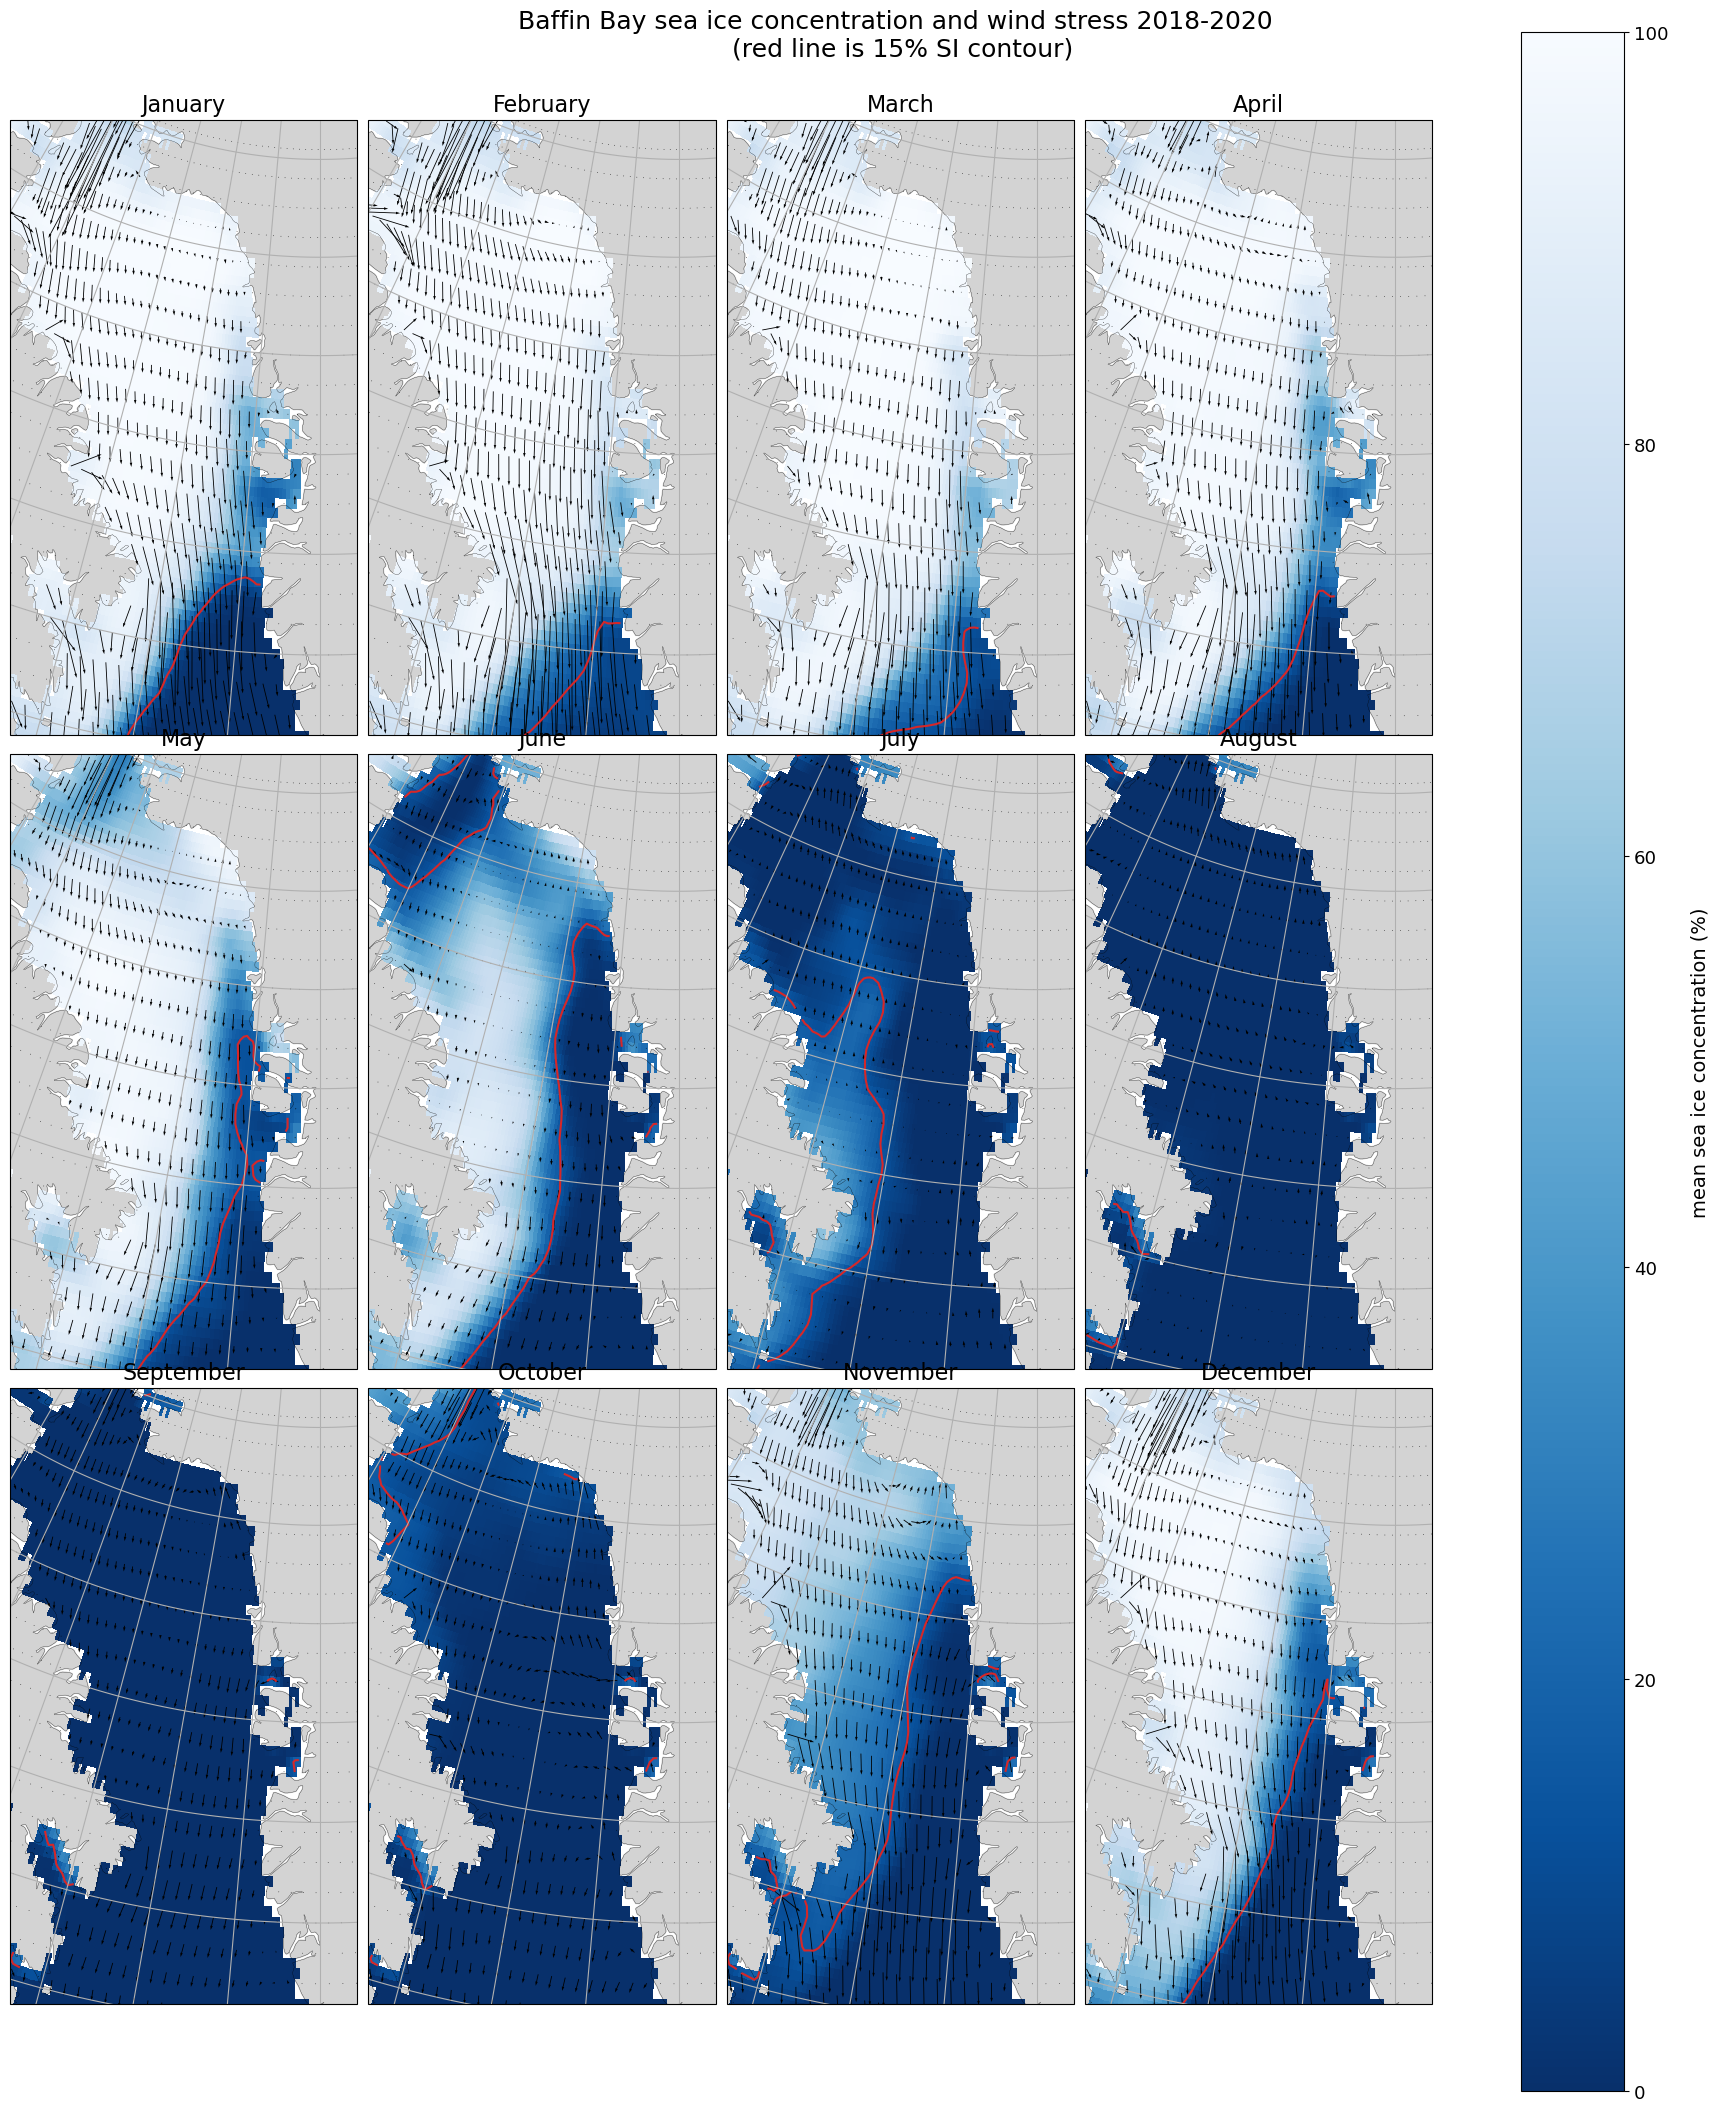

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import calendar

months = list(range(12))
month_names = list(calendar.month_name)[1:]

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 23),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-50)})
plt.subplots_adjust(hspace=0.2,wspace=0.1)
fig.suptitle("Baffin Bay sea ice concentration and wind stress 2018-2020 \n (red line is 15% SI contour)", fontsize=18, y=0.91)

plt.tight_layout(pad=0.8, w_pad=1, h_pad=2.0)
plt.subplots_adjust(top=0.9)

# loop through 
for month, ax in zip(months, axs.ravel()):
    # chart formatting
    ax.set_extent([-67, -48, 63, 78], ccrs.PlateCarree()) # Limit the map extent
    ax.add_feature(cfeature.COASTLINE, facecolor='k',linewidth=0.2)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    gl = ax.gridlines()
    
    # add sea ice concentration ---------------------
    seaice_percent_2018to2020 = seaice_month_2018to2020.siconc*100 # make a percentage
    pc = seaice_percent_2018to2020.isel(month=month).plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap="Blues_r", add_colorbar=False)
    
    # plot "zero" contour line (I set this to 15% sea ice cover)
    seaice_percent_2018to2020.isel(month=month).plot.contour(ax=ax,transform=ccrs.PlateCarree(),colors=["tab:red"], levels=[15], linewidths=1.5)

    # plot wind stress vectors
    x = np.array(tau_month_2018to2020.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)).longitude)
    y = np.array(tau_month_2018to2020.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)).latitude)
    u = np.array(tau_month_2018to2020.iews.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)))
    v = np.array(tau_month_2018to2020.inss.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)))
    Q = ax.quiver(x=x, y=y, u=u, v=v, transform=ccrs.PlateCarree(), scale_units = "inches", scale=0.3, headaxislength=5)
    # qk = ax.quiverkey(Q, 0.8, 1.02, 0.1, r'0.1 Nm$^{-2}$', labelpos='E',zorder=4)
    
    # set titles for each subplot
    ax.set_title(month_names[month], fontsize=16)
        
cax,kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
cbar = plt.colorbar(pc, cax=cax, **kw)
cbar.set_label('mean sea ice concentration (%)', rotation=90, fontsize=14)
cbar.ax.get_yaxis().labelpad = 16
cbar.ax.tick_params(labelsize=13)

# plt.savefig("figures/BaffinBay_windandice.png")

plt.show()

Now make plot for Melville Bay

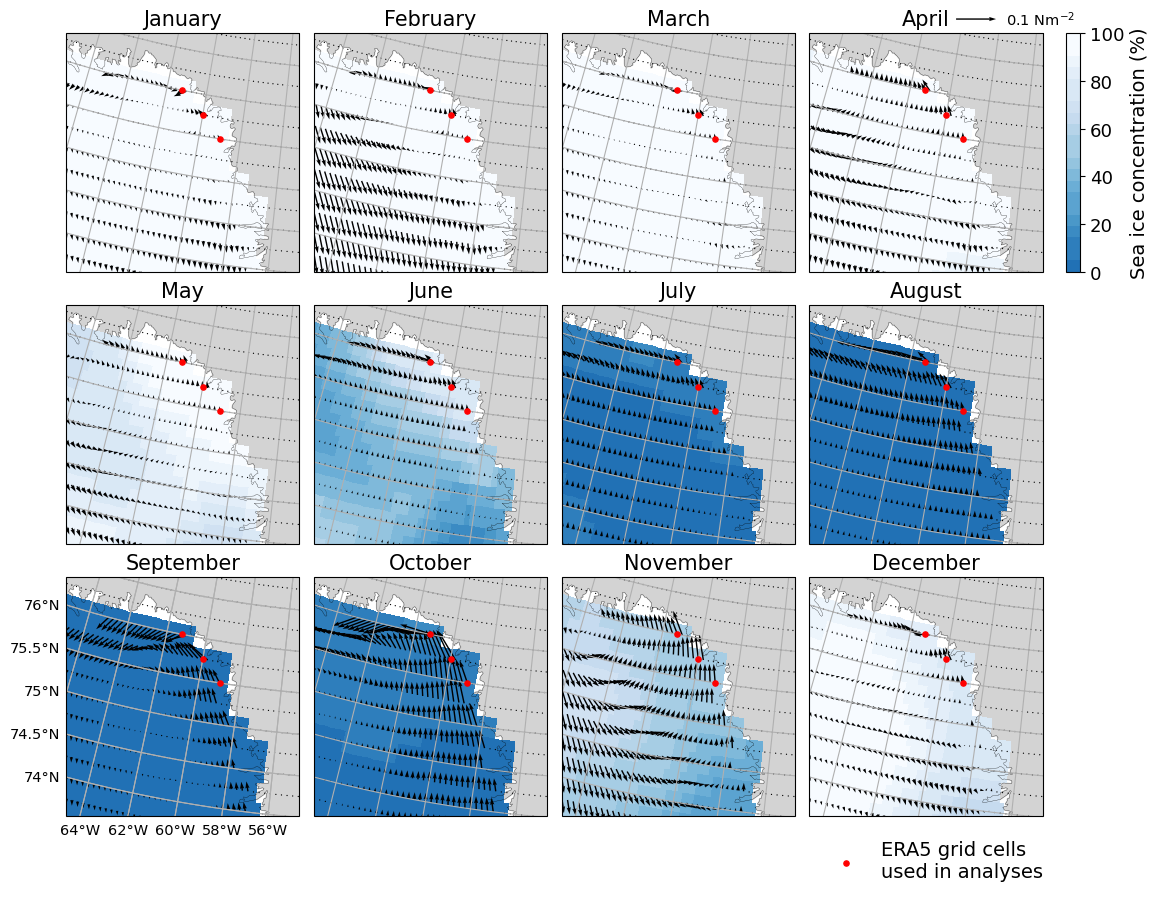

In [20]:
plt.rcParams['font.size'] = '10.5'
months = list(range(12))
month_names = list(calendar.month_name)[1:]

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 10),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-50)})
# plt.subplots_adjust(hspace=0.1,wspace=0.1)

plt.tight_layout(pad=0.8, w_pad=1, h_pad=2.2)
plt.subplots_adjust(top=0.85)

# loop through 
for month, ax in zip(months, axs.ravel()):
    # chart formatting
    ax.set_extent([-65, -55.5, 74, 76.5], ccrs.PlateCarree()) # Limit the map extent
    # ax.set_extent([-65, -55, 74, 76.5], ccrs.PlateCarree()) # Limit the map extent
    ax.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=0.2)
    ax.add_feature(cfeature.LAND, color='lightgray')
    gl = ax.gridlines()
    
    # add sea ice concentration ---------------------
    # make custom colormap
    ice_water = cm.get_cmap("Blues_r", 21)
    ice_water_cmap = ListedColormap(ice_water(np.linspace(0.25, 1, 21)))
    # plot sea ice
    seaice_percent_2018to2020 = seaice_month_2018to2020.siconc*100 # make a percentage
    pc = seaice_percent_2018to2020.isel(month=month).plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap=ice_water_cmap, add_colorbar=False)

    # plot wind stress vectors
    x = np.array(tau_month_2018to2020.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)).longitude)
    y = np.array(tau_month_2018to2020.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)).latitude)
    u = np.array(tau_month_2018to2020.iews.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)))
    v = np.array(tau_month_2018to2020.inss.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)))
    Q = ax.quiver(x=x, y=y, u=u, v=v, transform=ccrs.PlateCarree(), scale_units = "inches", scale=0.25, width=0.006)
    
    # set titles for each subplot
    ax.set_title(month_names[month], fontsize=15)
    
    ## Add red dots for the location of each grid cell used for the time series plots of ERA5 data
    ax.scatter(-60,75.75,color='r',s=14,transform=ccrs.PlateCarree(),zorder=6) # kong oscar
    ax.scatter(-59,75.5, color='r',s=14,transform=ccrs.PlateCarree(),zorder=6) # sverdrup
    ax.scatter(-61.25,76,color='r',s=14,transform=ccrs.PlateCarree(),zorder=6,label='ERA5 grid cells\nused in analyses') # rink

    # add key for quiver vectors
    if ax==axs.ravel()[3]:
        axins = inset_axes(
            axs.ravel()[3],
            width="6%",  # width: 5% of parent_bbox width
            height="100%",
            loc="upper left",
            bbox_to_anchor=(1.1, 0., 1, 1),
            bbox_transform=axs.ravel()[3].transAxes,
            borderpad=0)
        # cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=np.arange(1,13))
        cbar = fig.colorbar(pc, cax=axins)
        cbar.set_label('Sea ice concentration (%)', rotation=90, fontsize=14)
        # cbar.ax.get_yaxis().labelpad = 12
        cbar.ax.tick_params(labelsize=13)
        ax.quiverkey(Q, 0.8, 1.06, 0.1, r'0.1 Nm$^{-2}$', labelpos='E',zorder=4)
        
    # add legend for red dots
    if ax==axs.ravel()[11]:
        ax.legend(prop={'size': 14},bbox_to_anchor=(0, -0.03), loc='upper left',frameon=False)
        
    # add lat/lon labels to bottom left plot 
    if ax==axs.ravel()[8]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,\
                          xpadding=5, ypadding=4, rotate_labels=False)
        gl.top_labels = False
        gl.right_labels = False

plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/Analyses-and-plots/figures/MelvilleBay_windstress_seaice.png",\
            bbox_inches='tight', dpi=300, facecolor='white')

plt.show()

***

## Now we want to set wind stress = 0 when sea ice conc > 50% and compute wind stress curl and vertical velocity, $w_{ek}$

(1) Mask wind stress values (tau=0) when sea ice conc > 50%

In [21]:
# mask tau 2018-2020 data to isolate only open ocean wind stress (i.e., apply 0 to instances when the area is covered with sea ice)
# the dims and grid cells are the same for these two datasets
tau_x_1d_2018to2020_openocean = tau_1d_2018to2020.iews.where(seaice_1d_2018to2020.siconc < 0.5, 0)
tau_y_1d_2018to2020_openocean = tau_1d_2018to2020.inss.where(seaice_1d_2018to2020.siconc < 0.5, 0)

(2) Mask grid cells (zero) that have > 20% land cover (i.e., isolate ocean grid cells)

In [22]:
# now zero grid cells that have > 20% land cover
tau_x_1d_2018to2020_ocean_masked = tau_x_1d_2018to2020_openocean.where(tau_1d_2018to2020.lsm < 0.2, 0)
tau_y_1d_2018to2020_ocean_masked = tau_y_1d_2018to2020_openocean.where(tau_1d_2018to2020.lsm < 0.2, 0)

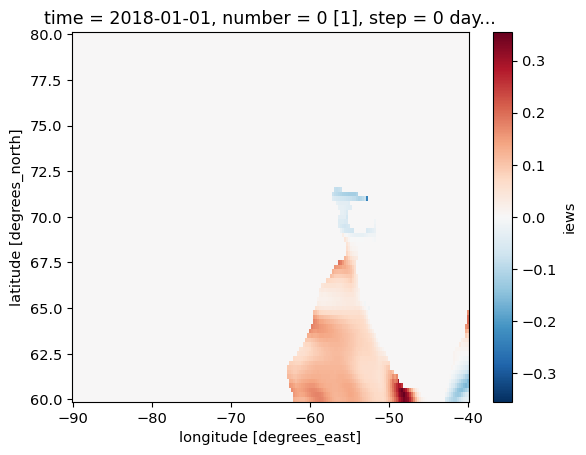

In [23]:
tau_x_1d_2018to2020_ocean_masked.isel(time=0).plot()

(3) Plot monthly average of sea ice concentration and wind stress vectors to make sure mask worked

In [24]:
# take monthly average
tau_x_month_2018to2020_ocean_masked = tau_x_1d_2018to2020_ocean_masked.groupby("time.month").mean(dim='time')
tau_y_month_2018to2020_ocean_masked = tau_y_1d_2018to2020_ocean_masked.groupby("time.month").mean(dim='time')

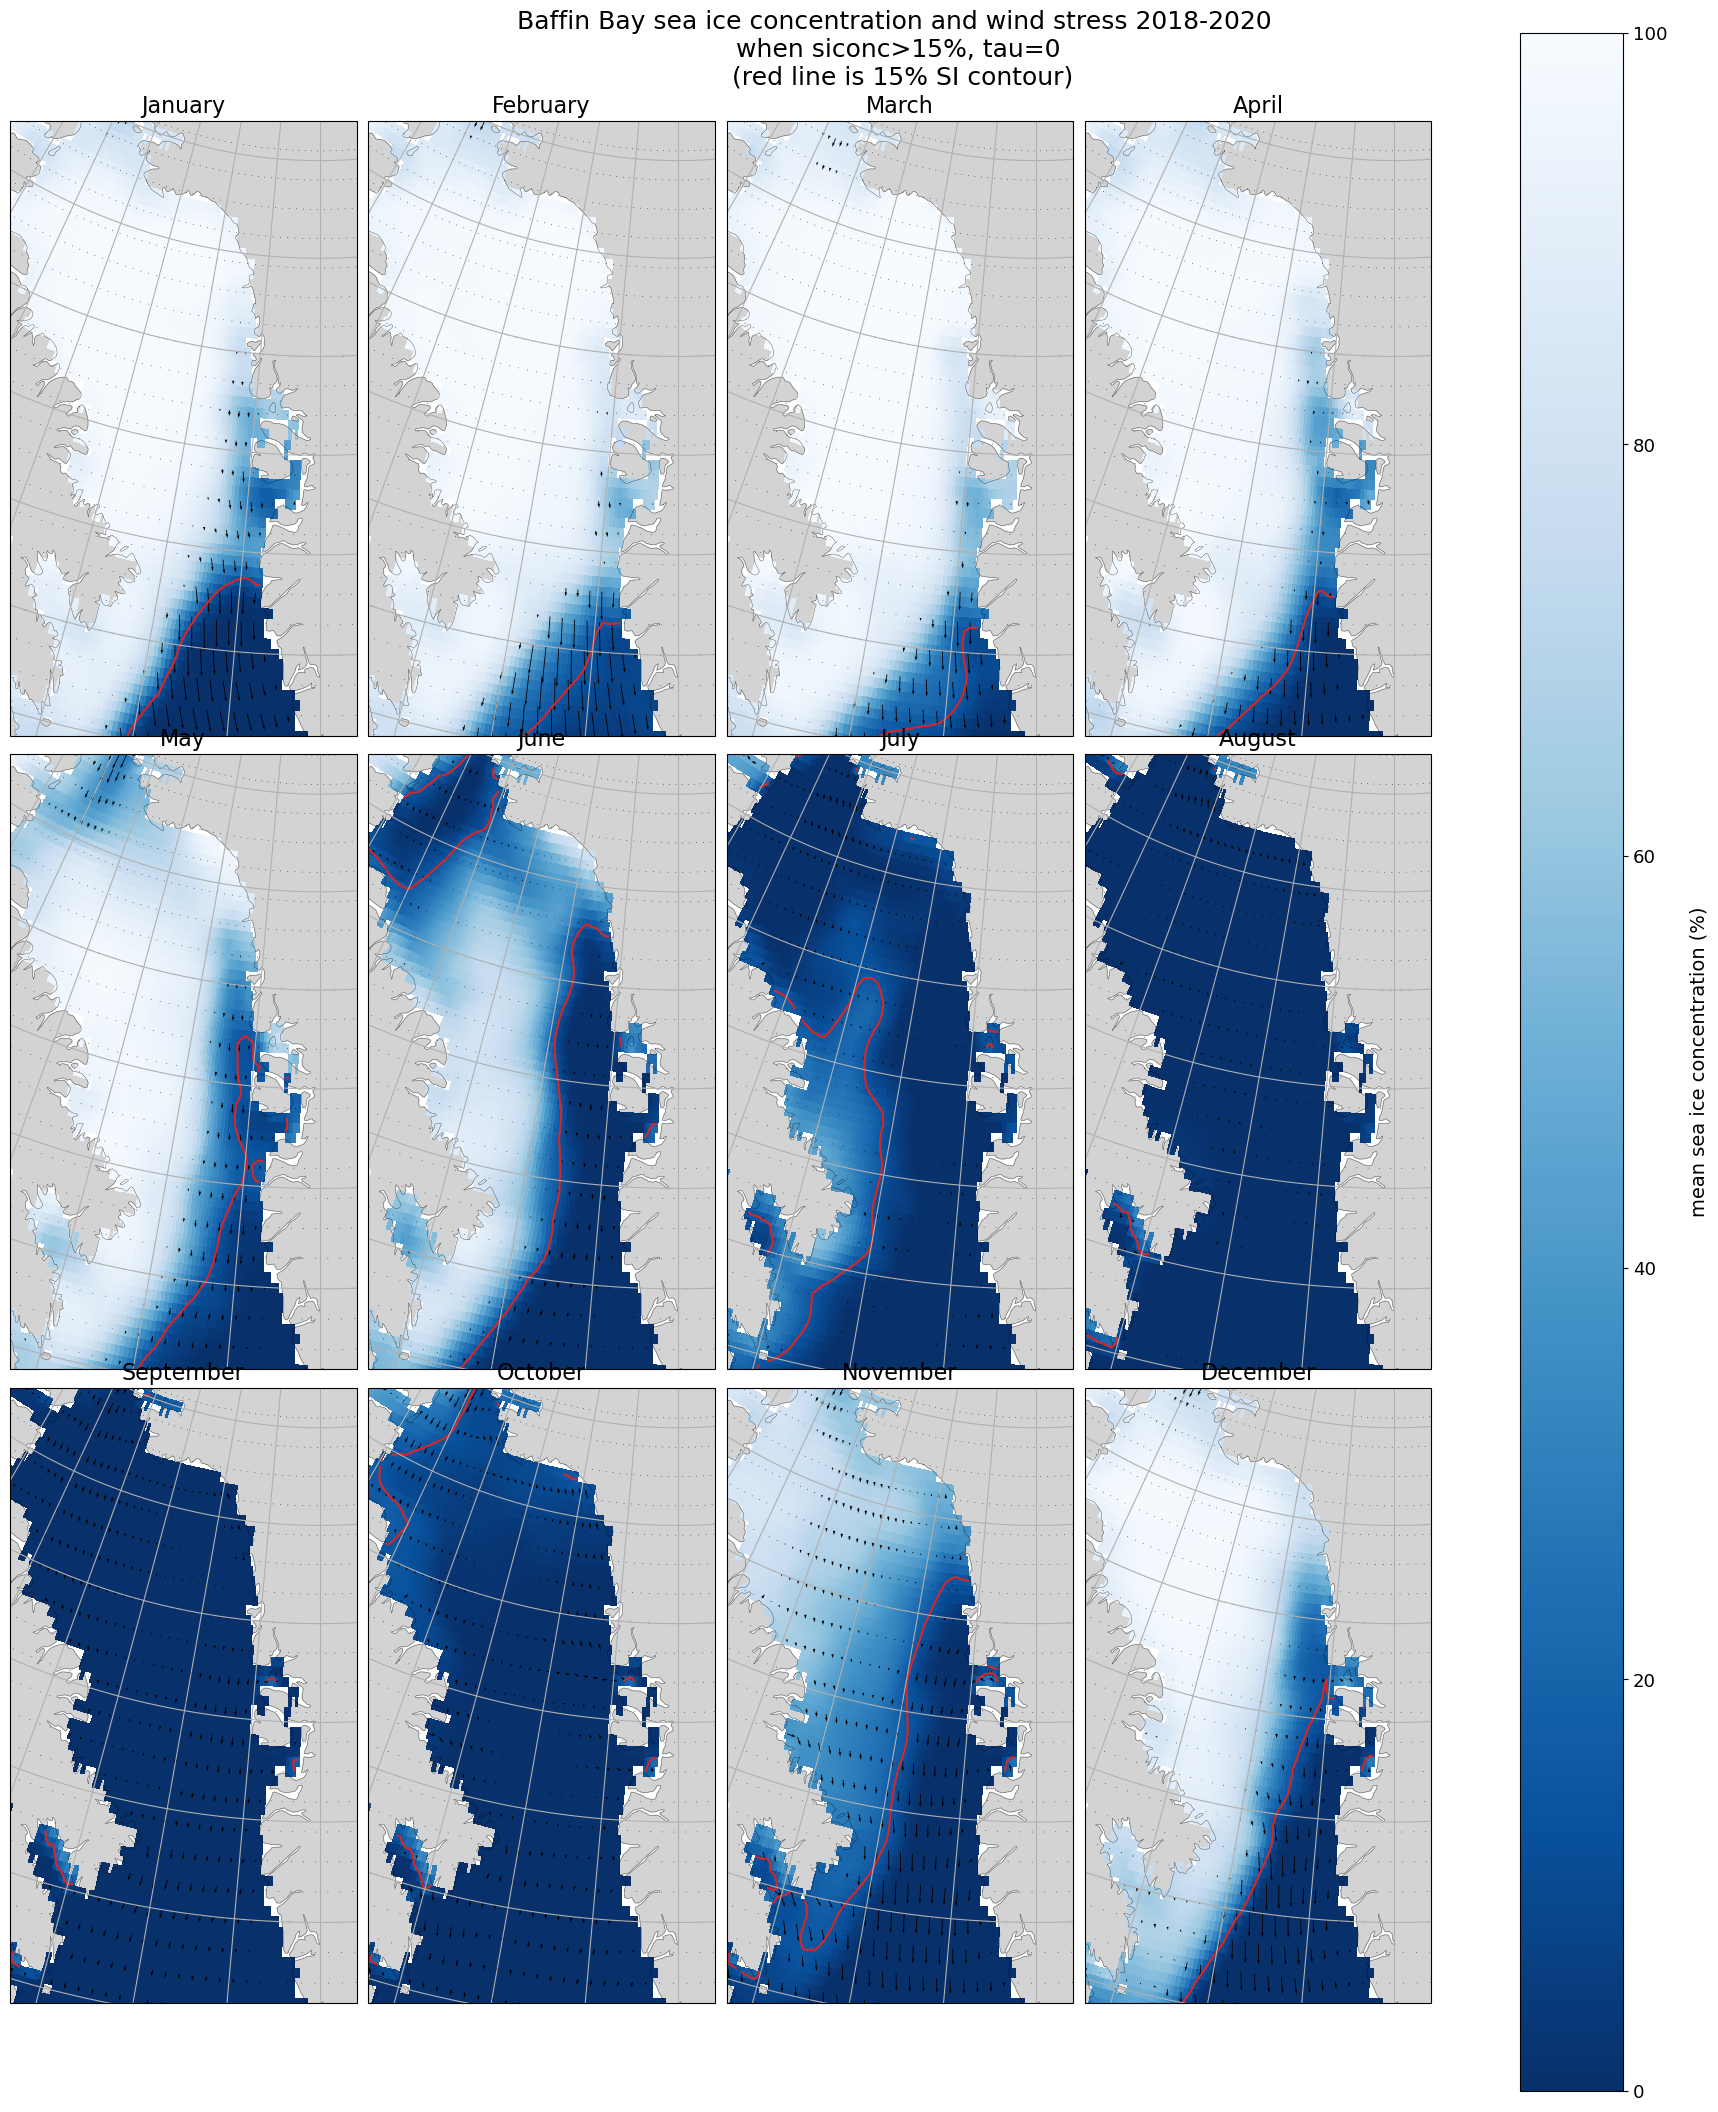

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import calendar

months = list(range(12))
month_names = list(calendar.month_name)[1:]

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 23),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-50)})
plt.subplots_adjust(hspace=0.2,wspace=0.1)
fig.suptitle("Baffin Bay sea ice concentration and wind stress 2018-2020 \n when siconc>15%, tau=0 \n (red line is 15% SI contour)", fontsize=18, y=0.91)

plt.tight_layout(pad=0.8, w_pad=1, h_pad=2.0)
plt.subplots_adjust(top=0.9)

# loop through 
for month, ax in zip(months, axs.ravel()):
    # chart formatting
    ax.set_extent([-67, -48, 63, 78], ccrs.PlateCarree()) # Limit the map extent
    ax.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=0.2)
    ax.add_feature(cfeature.LAND, color='lightgray')
    gl = ax.gridlines()
    
    # add sea ice concentration ---------------------
    seaice_percent_2018to2020 = seaice_month_2018to2020.siconc*100 # make a percentage
    pc = seaice_percent_2018to2020.isel(month=month).plot(ax=ax,transform=ccrs.PlateCarree(), vmin=0, vmax=100, cmap="Blues_r", add_colorbar=False)
    
    # plot "zero" contour line (I set this to 15% sea ice cover)
    seaice_percent_2018to2020.isel(month=month).plot.contour(ax=ax,transform=ccrs.PlateCarree(),colors=["tab:red"], levels=[15], linewidths=1.5)

    # plot wind stress vectors
    x = np.array(tau_x_month_2018to2020_ocean_masked.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)).longitude)
    y = np.array(tau_x_month_2018to2020_ocean_masked.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)).latitude)
    u = np.array(tau_x_month_2018to2020_ocean_masked.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)))
    v = np.array(tau_y_month_2018to2020_ocean_masked.isel(month=month, longitude=slice(None,None,3), latitude = slice(None,None,3)))
    Q = ax.quiver(x=x, y=y, u=u, v=v, transform=ccrs.PlateCarree(), scale_units = "inches", scale=0.6, headaxislength=5)
    # qk = ax.quiverkey(Q, 0.8, 1.02, 0.1, r'0.1 Nm$^{-2}$', labelpos='E',zorder=4)
    
    # set titles for each subplot
    ax.set_title(month_names[month], fontsize=16)
        
cax,kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
cbar = plt.colorbar(pc, cax=cax, **kw)
cbar.set_label('mean sea ice concentration (%)', rotation=90, fontsize=14)
cbar.ax.get_yaxis().labelpad = 16
cbar.ax.tick_params(labelsize=13)

# plt.savefig("figures/BaffinBay_windandice_mask.png")

plt.show()


The mask worked. I think November and December are a bit odd because I implemented the mask before monthly-averaging the data.

### Now recalculate wind stress curl and Ekman pumping

In [26]:
# calculate deltas: ∂τy/∂x - ∂τx/∂y

# reverse order of latitude coordinate since it is in decreasing order and we need increasing (northward)
tau_x_1d_ocean = tau_x_1d_2018to2020_ocean_masked.reindex(latitude=list(reversed(tau_x_1d_2018to2020_ocean_masked.latitude)))
tau_y_1d_ocean = tau_y_1d_2018to2020_ocean_masked.reindex(latitude=list(reversed(tau_y_1d_2018to2020_ocean_masked.latitude)))

# ∂τy (northward component) - change in wind stress in y in the x direction
delta_tau_y_BB_1d = tau_y_1d_ocean.diff(dim='longitude',label='lower')
# ∂τx (eastward component) - change in wind stress in x in the y direction
delta_tau_x_BB_1d = tau_x_1d_ocean.diff(dim='latitude',label='lower')

# need to calculate approximate length of each grid cell in meters
# there are ~111.11 km per 1 deg latitude and each grid cell is 0.25 degrees latitude = 27.75 km
# longitude grid cell in meters can be approximated as latitude*4: (cos(latitude) = cos(75.5 deg) = 0.25; 1/0.25 = 4; 4*lat = lon)
delta_x = 6944 # each grid square is 0.25 deg lon = 27.8 km/4 = 6,944 m
delta_y = 27778 # 0.25 deg latitude = 27.75 km = 27,778 m

# calculate wind stress curl
curl_BB_1d = (delta_tau_y_BB_1d/delta_x) - (delta_tau_x_BB_1d/delta_y)

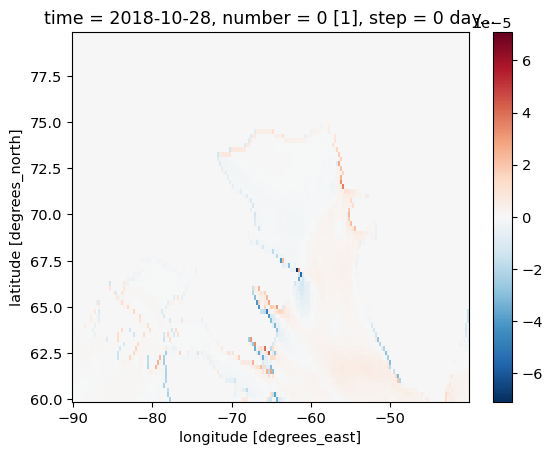

In [27]:
curl_BB_1d.isel(time=300).plot()

#### Scale wind stress grid cells by percent sea ice (wind stress curl/(1-SI%)) <br>
This will increase wind stress curl at sea ice edge/front

In [28]:
# mask sea ice dataset for when sea ice is > 50%
seaice_1d_2018to2020_masked = seaice_1d_2018to2020.siconc.where(seaice_1d_2018to2020.siconc < 0.5, 0)

In [29]:
# scale wind stress curl by open water area (1-SI)
curl_BB_1d_scaled = curl_BB_1d / (1 - seaice_1d_2018to2020_masked)

Sanity check: compare wind stress value before and after it was scaled

In [30]:
print("curl before scaling: ", curl_BB_1d.sel(time='2019-11-20', longitude=-60, latitude=75).values)
print("sea ice conc: ", seaice_1d_2018to2020.siconc.sel(time='2019-11-20', longitude=-60, latitude=75).values)
print("curl after scaling: ", curl_BB_1d_scaled.sel(time='2019-11-20', longitude=-60, latitude=75).values)

curl before scaling:  7.8149804e-07
sea ice conc:  0.007209778
curl after scaling:  7.871734e-07


In [31]:
# subset region for Melville Bay
curl_melville_1d_scaled = curl_BB_1d_scaled.sel(longitude=slice(-61.5,-60.5), latitude=slice(75,75.5))

In [32]:
# select region in Melville Bay
seaice_1d_melville = seaice_1d_2018to2020.siconc.sel(longitude=slice(-61.5,-60.5), latitude=slice(75.5, 75))

In [20]:
siconc = seaice_1d_2018to2020.siconc

In [33]:
# select regions in each fjord
seaice_1d_KO = seaice_1d_2018to2020.siconc.sel(longitude=-59.8429, latitude=75.843683, method="nearest")
seaice_1d_sverdrup = seaice_1d_2018to2020.siconc.sel(longitude=-58.410533, latitude=75.5413, method="nearest")
seaice_1d_rink = seaice_1d_2018to2020.siconc.sel(longitude=-61.279117, latitude=76.160533, method="nearest")

In [22]:
# isolate mask for plot
seaice_1d_KO = siconc.where(siconc.latitude == 75.75,np.nan) * siconc.where(siconc.longitude == -60,np.nan)
# seaice_1d_sverdrup = siconc.where(siconc.latitude == 75.25,np.nan) * siconc.where(siconc.longitude == -58.75,np.nan)
seaice_1d_sverdrup = siconc.where(siconc.latitude == 75.5,np.nan) * siconc.where(siconc.longitude == -59,np.nan)
seaice_1d_rink = siconc.where(siconc.latitude == 76,np.nan) * siconc.where(siconc.longitude == -61.25,np.nan)
seaice_1d_fisher = siconc.where(siconc.latitude == 76,np.nan) * siconc.where(siconc.longitude == -61.75,np.nan)

## Calculate ekman pumping, $w_{ek}$

In [34]:
coriolis = 2*(7.2921e-5)*math.sin(75*math.pi/180) # s^−1
rho = 1027 # kg/m^3

In [35]:
## calculate Ekman pumping in Baffin Bay
## w_ek = curl/ρf
w_ek_1d = curl_BB_1d_scaled/(rho*coriolis)

In [36]:
# take monthly mean
w_ek_month_group = w_ek_1d.groupby('time.month').mean(dim='time')
w_ek_month = w_ek_1d.resample(time="1M").mean()

In [37]:
# estimate vertical transport per day
# 86400 seconds per day

w_ek_1d_perday = w_ek_1d*86400
w_ek_month_perday = w_ek_month*86400
w_ek_month_group_perday = w_ek_month_group*86400 # group refers to montly mean across all years 2018-2020

We see w_ek is positive along the west coast of Greenland where there is upwelling (divergence) at the base of the Ekman layer

In [38]:
## Zoom into Melville Bay
# w_ek_day_melville = w_ek_month_perday.sel(longitude=slice(-62.75,-57),latitude=slice(75,76.5))
# w_ek_day_group_melville = w_ek_month_group_perday.sel(longitude=slice(-62.75,-57),latitude=slice(75,76.5))

w_ek_day_melville = w_ek_1d_perday.sel(longitude=slice(-67.5,-56),latitude=slice(73,76.5))
w_ek_month_melville = w_ek_month_perday.sel(longitude=slice(-65,-56),latitude=slice(74,76.5))
w_ek_day_group_melville = w_ek_month_group_perday.sel(longitude=slice(-65,-56),latitude=slice(74,76.5))

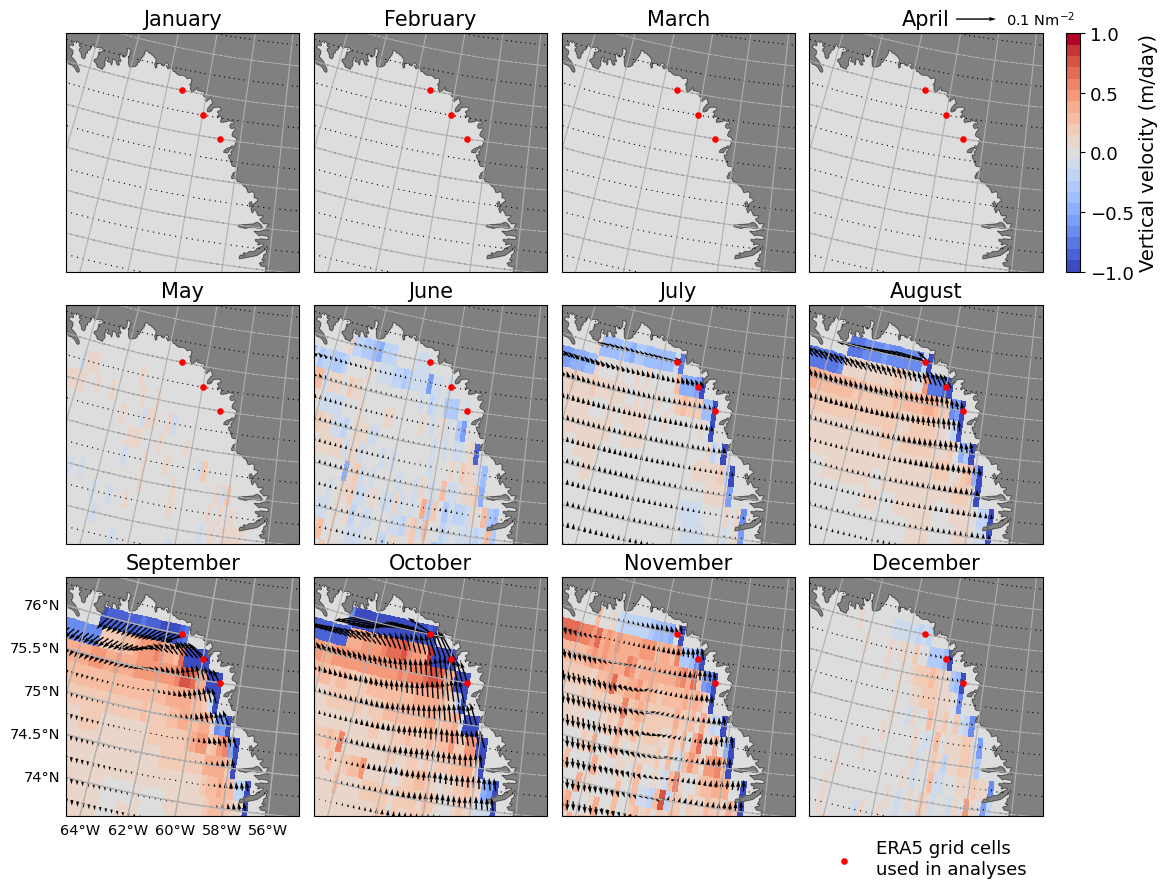

In [39]:
plt.rcParams['font.size'] = '10.5'
months = list(range(12))
month_names = list(calendar.month_name)[1:]

# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 10),subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-50)})
plt.tight_layout(pad=0.8, w_pad=1, h_pad=2.2)
plt.subplots_adjust(top=0.85)

# select wider region for melville bay
w_ek_day_group_melville = w_ek_month_group_perday.sel(longitude=slice(-70,-56),latitude=slice(73,77))

# take monthly mean for ocean masked tau dataset
tau_x_month_12 = tau_x_1d_2018to2020_ocean_masked.groupby("time.month").mean(dim='time')
tau_y_month_12 = tau_y_1d_2018to2020_ocean_masked.groupby("time.month").mean(dim='time')

# loop through 
for month, ax in zip(months, axs.ravel()):
    # make custom colormap
    ekman = cm.get_cmap("coolwarm", 21)
    ekman_cmap = ListedColormap(ekman(np.linspace(0, 1, 21)))
    pc=w_ek_day_group_melville.isel(month=month).plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-1, vmax=1, add_colorbar=False, cmap=ekman_cmap)
    
    # chart formatting
    ax.set_extent([-65, -55.5, 74, 76.5], ccrs.PlateCarree()) # Limit the map extent
    ax.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=0.2)
    ax.add_feature(cfeature.LAND, color='gray',zorder=1)
    gl = ax.gridlines()
    
    ax.set_title(month_names[month], fontsize=15)
    
    # plot wind stress vectors
    x = np.array(tau_x_month_12.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)).longitude)
    y = np.array(tau_x_month_12.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)).latitude)
    u = np.array(tau_x_month_12.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)))
    v = np.array(tau_y_month_12.isel(month=month, longitude=slice(None,None,1), latitude = slice(None,None,1)))
    Q = ax.quiver(x=x, y=y, u=u, v=v, transform=ccrs.PlateCarree(), scale_units = "inches", scale=0.25, width=0.006)
    
    ## Add red dots for the location of each grid cell used for the time series plots of ERA5 data
    ax.scatter(-60,75.75,color='r',s=14,transform=ccrs.PlateCarree(),zorder=6) # kong oscar
    ax.scatter(-59,75.5, color='r',s=14,transform=ccrs.PlateCarree(),zorder=6) # sverdrup
    ax.scatter(-61.25,76,color='r',s=14,transform=ccrs.PlateCarree(),zorder=6,label='ERA5 grid cells\nused in analyses') # rink
    
    # add key for quiver vectors and colorbar
    if ax==axs.ravel()[3]:
        axins = inset_axes(
            axs.ravel()[3],
            width="6%",  # width: 5% of parent_bbox width
            height="100%",
            loc="upper left",
            bbox_to_anchor=(1.1, 0., 1, 1),
            bbox_transform=axs.ravel()[3].transAxes,
            borderpad=0)
        # cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=axins, ticks=np.arange(1,13))
        cbar = fig.colorbar(pc, cax=axins)
        cbar.set_label('Vertical velocity (m/day)', rotation=90, fontsize=14)
        # cbar.ax.get_yaxis().labelpad = 12
        cbar.ax.tick_params(labelsize=13)
        ax.quiverkey(Q, 0.8, 1.06, 0.1, r'0.1 Nm$^{-2}$', labelpos='E',zorder=4)
        
    # add legend for red dots
    if ax==axs.ravel()[11]:
        ax.legend(prop={'size': 13},bbox_to_anchor=(0, -0.03), loc='upper left',frameon=False)
    # add lat/lon labels to bottom left plot 
    if ax==axs.ravel()[8]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,\
                          xpadding=5, ypadding=4, rotate_labels=False)
        gl.top_labels = False
        gl.right_labels = False

plt.savefig("C:/Users/marie/Documents/PhD/Chapter_3/OMG_manuscript_Github/OMG_Narwhals_hydrography-manuscript/Analyses-and-plots/figures/MelvilleBay_ekman_windstress.png",\
            bbox_inches='tight', dpi=300, facecolor='white')

plt.show()